In [111]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel


import random
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Data

The data will be a small subset of the well known handwritten [digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset), which is available through scikit-learn. The task is to differentiate between '0' and '1'. 

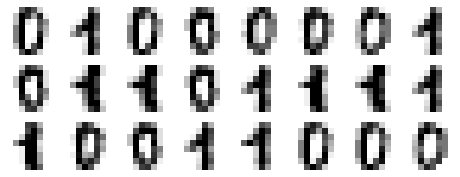

In [127]:

digits = datasets.load_digits(n_class=2)

rows = 3
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(8,3))

for i in range(rows):
    for j in range(cols):
        axs[i,j].set_axis_off()
        axs[i,j].imshow(digits.images[random.randint(0,9)], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Data Preprocessing

There are a total of 360 datapoints in the dataset. Each datapoint is a 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). As per classical classification, we need to split the dataset into training (100) and testing (20) samples, and normalise it. To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (4).
 

In [128]:
def print_dataset(title, sample_test, sample_train):
    print(f"""
    {title}
    {'-'*len(title)}
    TEST: {sample_test.shape}\tmax: {sample_test.max()}, min:{sample_test.min()}
    TRAIN:{sample_train.shape}\tmax: {sample_train.max()}, min:{sample_train.min()}
    """)
    fig, axs = plt.subplots(1, 2, figsize=(15,3))
    axs[0].hist(np.concatenate(sample_test))
    axs[1].scatter(sample_test[:,0], sample_test[:,1])
    plt.show()
    


    RAW Sample
    ----------
    TEST: (72, 64)	max: 16.0, min:0.0
    TRAIN:(288, 64)	max: 16.0, min:0.0
    


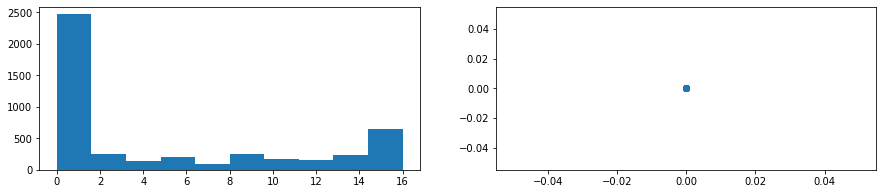

In [129]:
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

print_dataset('RAW Sample', sample_test, sample_train)


    PCA
    ---
    TEST: (72, 4)	max: 36.20601200898607, min:-28.684930979781353
    TRAIN:(288, 4)	max: 37.84226869327098, min:-30.093633866649082
    


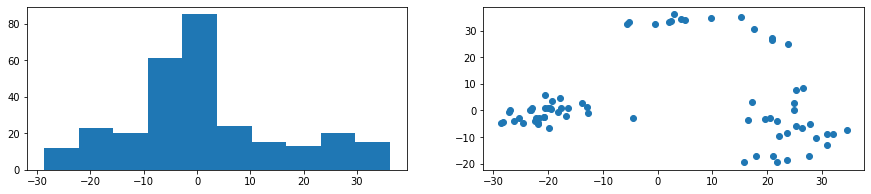


    StandardScaler
    --------------
    TEST: (72, 4)	max: 2.8880531738068442, min:-2.1136081473404036
    TRAIN:(288, 4)	max: 3.482104580681603, min:-2.4367761971771675
    


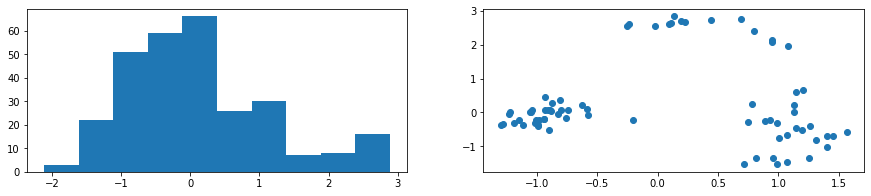


    minmax_scale
    ------------
    TEST: (72, 4)	max: 0.9999999999999999, min:-0.9563792815254213
    TRAIN:(288, 4)	max: 1.0, min:-1.0
    


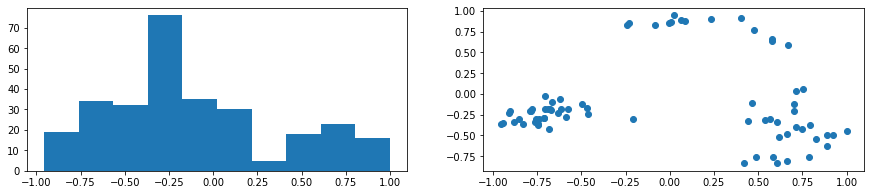

In [130]:

n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print_dataset('PCA', sample_test, sample_train)

std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

print_dataset('StandardScaler', sample_test, sample_train)

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

print_dataset('minmax_scale', sample_test, sample_train)

train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [42]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map.

### Quantum Feature Maps

As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The feature maps currently used are introduced in [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), in particular the `ZZFeatureMap` is thought to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

I want to implement a feature map similar to the one defined below:


$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

We now create a completely custom parameterised circuit feature map. To do so I can simply create a `QuantumCircuit` with a [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html)

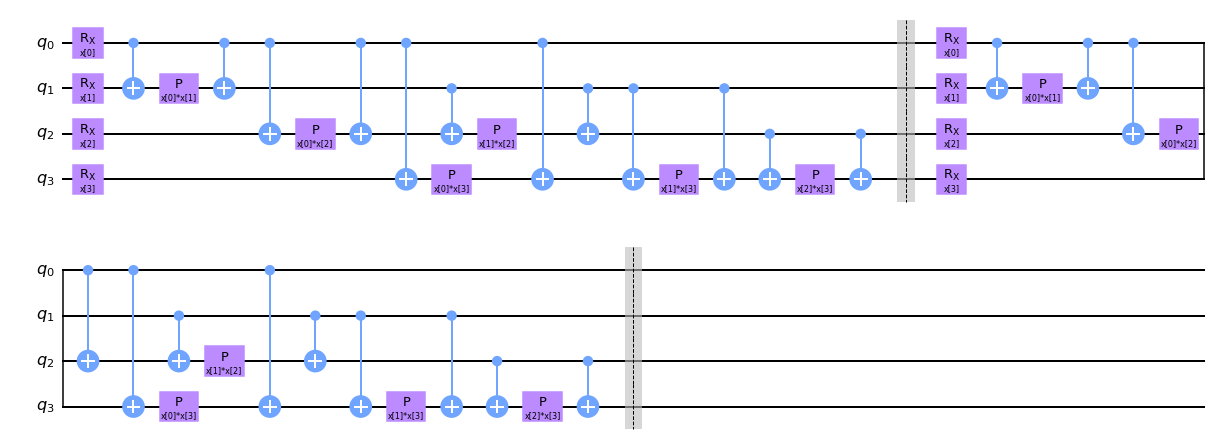

In [131]:
qubits = 4     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.draw('mpl')

Let's encode the first training sample using the `ZZFeatureMap`:

In [132]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


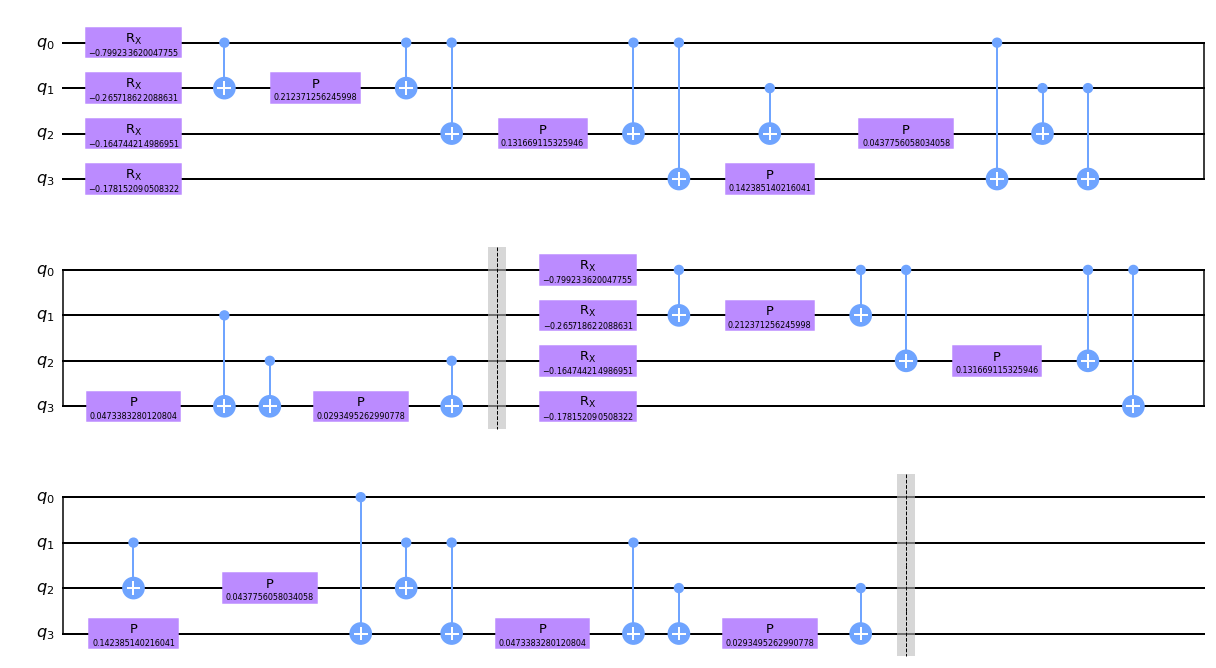

In [133]:
encode_circuit = var_custom.bind_parameters(sample_train[0])
encode_circuit.draw(output='mpl')

## Quantum Kernel Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 

When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

However, it was proven recently in [*Liu et al.* arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174) that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over allclassical learners.

With our training and testing datasets ready, we set up the `QuantumKernel` class with the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [134]:
zz_kernel = QuantumKernel(feature_map=var_custom, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [135]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


First we create and draw the circuit:

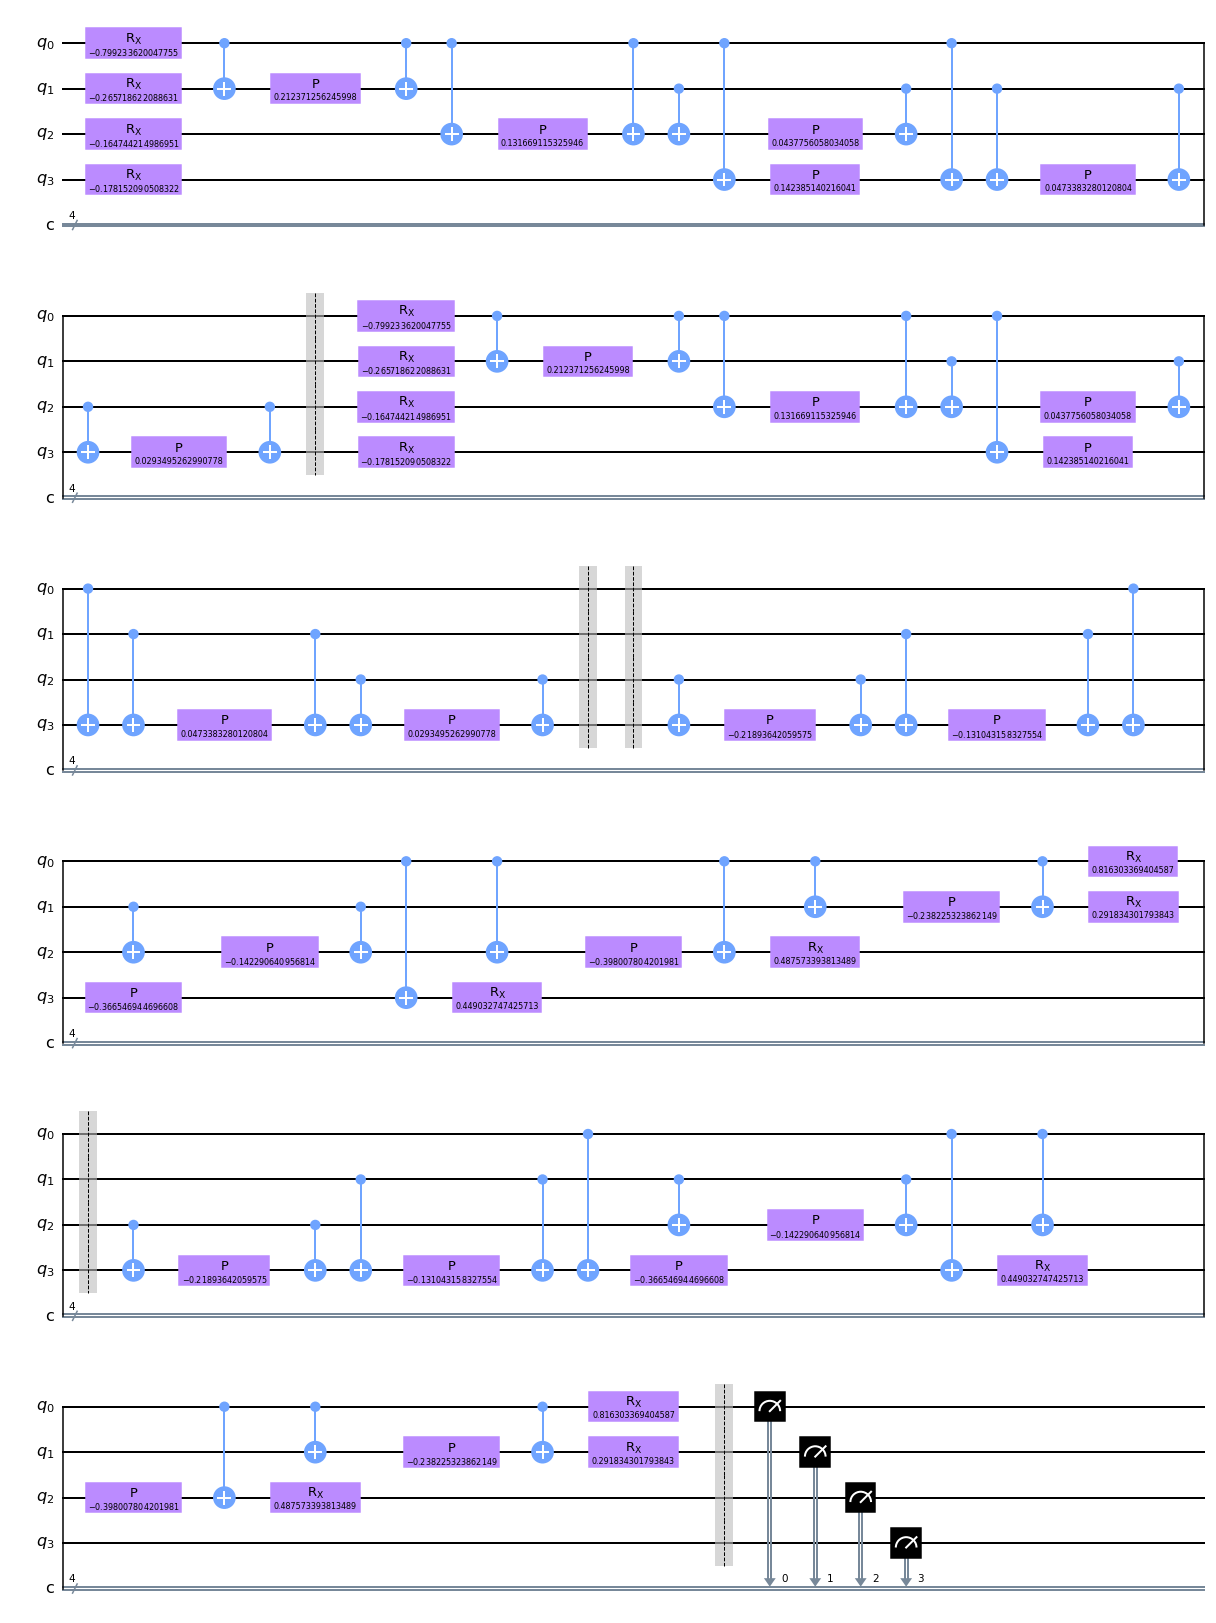

In [136]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')
zz_circuit.decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise. 

In [137]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, seed_simulator=1024, seed_transpiler=1024)
# counts = job.result().get_counts(zz_circuit)

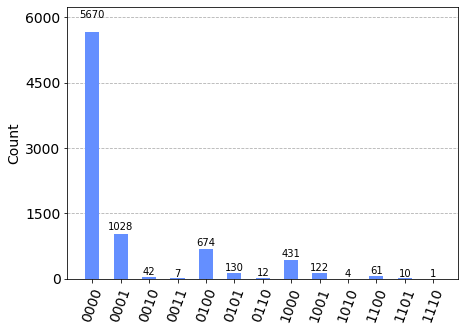

In [141]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

The transition amplitude is the proportion of counts in the zero state:

In [142]:
counts['0000']/sum(counts.values())

0.692138671875

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

Here we compute and plot the training and testing kernel matrices:

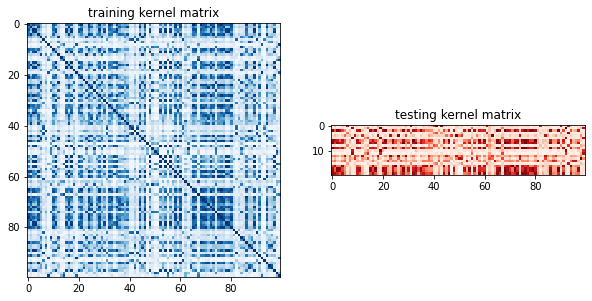

In [143]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [144]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 1.0


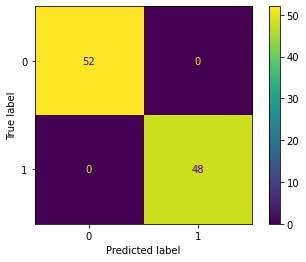

In [145]:
plot_confusion_matrix(zzpc_svc, matrix_train, label_train)

The following code gives the kernel as a callable function:

In [146]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 1.0


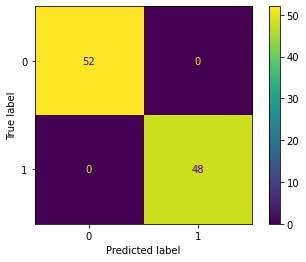

In [147]:
plot_confusion_matrix(zzcb_svc, sample_train, label_train)

This is convenient, as we can easily compare the quantum kernel with various classical kernels:

linear kernel classification test score:  1.00


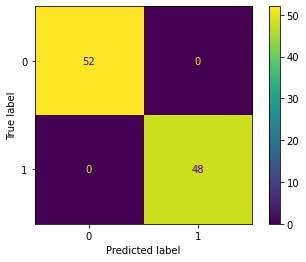

poly kernel classification test score:  0.95


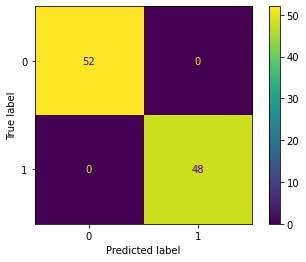

rbf kernel classification test score:  1.00


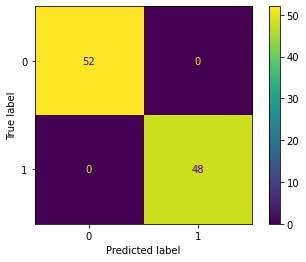

sigmoid kernel classification test score:  1.00


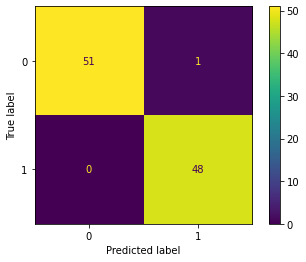

In [148]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))
    plot_confusion_matrix(classical_svc, sample_train, label_train)
    plt.show()